In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install tqdm
import pandas as pd

Mounted at /content/drive


## 전처리

### 불러오기 (이제 생략가능)

In [ ]:
merged_data_cleaned = pd.read_csv('/content/drive/MyDrive/기계학습/데이터/temp0502_풍+질+대')
final_dataframe = pd.read_csv('/content/drive/MyDrive/기계학습/데이터/기상관측소 주변행정구역 위경도기반 클러스터링결과v2.csv', encoding='euc-kr')

In [ ]:
# 관리관서와 시군구가 모두 있는 경우 조사
merged_data_cleaned['시군구'] = merged_data_cleaned['시군구'].str.replace(" ", "")
complete_data = merged_data_cleaned[merged_data_cleaned['관리관서'].notna() & merged_data_cleaned['시군구'].notna()]
complete_sigu = complete_data['시군구'].unique()
complete_admin_office = complete_data['관리관서'].unique()

# 관리관서가 없는 시군구
missing_admin_office = merged_data_cleaned[merged_data_cleaned['관리관서'].isna()]['시군구'].unique()

A = complete_sigu
B = missing_admin_office

# 공백 제거 (시군구 및 시군구_로컬 컬럼에 적용)
merged_data_cleaned['시군구_조정'] = merged_data_cleaned['시군구'].str.replace(" ", "")
final_dataframe['시군구_로컬_조정'] = final_dataframe['시군구_로컬'].str.replace(" ", "")

# 외부 조인 실행
merged_result = pd.merge(merged_data_cleaned, final_dataframe, left_on='시군구_조정', right_on='시군구_로컬_조정', how='outer')
data = merged_result

In [ ]:
final_dataframe['시군구_로컬_조정'].nunique()

156

In [ ]:
final_dataframe['시군구_로컬_조정'].unique()

array(['서울중구', '서울용산구', '서울성동구', '서울광진구', '서울동대문구', '서울중랑구', '서울성북구',
       '서울강북구', '서울도봉구', '서울노원구', '서울은평구', '서울서대문구', '서울마포구', '서울양천구',
       '서울강서구', '서울구로구', '서울금천구', '서울영등포구', '서울동작구', '서울관악구', '서울서초구',
       '서울강남구', '서울송파구', '서울강동구', '부산서구', '부산동구', '부산영도구', '부산부산진구',
       '부산동래구', '부산남구', '부산북구', '부산해운대구', '부산사하구', '부산금정구', '부산강서구',
       '부산연제구', '부산수영구', '부산사상구', '부산기장군', '대구중구', '대구동구', '대구서구', '대구남구',
       '대구북구', '대구수성구', '대구달서구', '대구달성군', '인천중구', '인천동구', '인천연수구',
       '인천남동구', '인천부평구', '인천계양구', '인천서구', '인천옹진군', '광주동구', '광주서구', '광주남구',
       '광주광산구', '대전동구', '대전중구', '대전서구', '대전대덕구', '울산중구', '울산남구', '울산동구',
       '울산북구', '울산울주군', '경기성남시', '경기의정부시', '경기안양시', '경기부천시', '경기광명시',
       '경기평택시', '경기안산시', '경기고양시', '경기과천시', '경기구리시', '경기남양주시', '경기오산시',
       '경기시흥시', '경기군포시', '경기의왕시', '경기하남시', '경기용인시', '경기안성시', '경기김포시',
       '경기화성시', '경기광주시', '경기양주시', '경기포천시', '경기여주시', '경기연천군', '경기가평군',
       '강원속초시', '강원삼척시', '강원횡성군', '강원화천군', '강원양구군', '강원고성군', '강원양양군',
       '충

In [ ]:
data.sample()

,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
71656,135820,2018-09-24,경남함양군,창원기상대(155),35.5114,127.7454,0.5,250.0,NaN,NaN,...,0.0,0.0,경남함양군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 풍향 결측치 채우기 (인근 관리관서 기준, 3개월 치 샘플링)

In [ ]:
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
import os
frecture = ''
# DATE 행 기준으로 2021-01-01~2022-01-01로 필터링하는 함수
def filter_data_by_date(data, start_date, end_date):
    data['DATE'] = pd.to_datetime(data['DATE'])
    return data[(data['DATE'] >= start_date) & (data['DATE'] <= end_date)].copy()

# 필요한 열 선택
columns_to_fill = ['관리관서', '위도', '경도', '평균풍속(m/s)', '최대풍속풍향(deg)']

# Load checkpoint if exists
checkpoint_file = f'/content/drive/MyDrive/기계학습/데이터/{frecture}checkpoint_202001_04.csv'
complete_file = f'/content/drive/MyDrive/기계학습/데이터/{frecture}complete_202001_04.csv'

if os.path.exists(checkpoint_file):
    filtered_data_sample = pd.read_csv(checkpoint_file, encoding='euc-kr')
    filtered_data_sample['DATE'] = pd.to_datetime(filtered_data_sample['DATE'])
    start_idx = filtered_data_sample[filtered_data_sample['관리관서'].isna()].index[0]
else:
    # '시군구' 열에서 NaN을 빈 문자열로 대체
    data['시군구'] = data['시군구'].fillna('')

    # '시군구'가 ''으로 시작하는 행만 필터링
    filtered_data = data[data['시군구'].str.startswith(frecture)].copy()

    # DATE 행 기준으로 2021-01-01~2022-01-01로 필터링
    filtered_data_sample = filter_data_by_date(filtered_data, '2020-01-01', '2020-04-01')
    start_idx = 0

# 결측치 채우기 전 '관리관서' 결측치 개수 확인
missing_before = filtered_data_sample['관리관서'].isna().sum()

# tqdm을 사용하여 진행 상황을 표시하며 결측치 채우기
for idx, row in tqdm(filtered_data_sample.iloc[start_idx:].iterrows(), total=filtered_data_sample.iloc[start_idx:].shape[0], desc="Filling missing data"):
    if pd.isna(row['관리관서']):
        # 같은 'DATE'에서 '시군구_관측소'와 일치하는 '시군구'를 가진 행을 찾음
        mask = (filtered_data_sample['DATE'] == row['DATE']) & (filtered_data_sample['시군구'] == row['시군구_관측소'])
        fill_data = filtered_data_sample.loc[mask, columns_to_fill]
        # 디버깅 출력
        if fill_data.empty:
            print(f"\n No match found for index {idx} with DATE {row['DATE']} and 시군구_관측소 {row['시군구_관측소']}")
        else:
            print(f"\n Match found for index {idx} with DATE {row['DATE']} and 시군구_관측소 {row['시군구_관측소']}")
        # 찾은 행에서 필요한 값 복사
        if not fill_data.empty:
            for col in columns_to_fill:
                row[col] = fill_data.iloc[0][col]
    filtered_data_sample.loc[idx] = row

    # Save checkpoint every 1000 rows
    if (idx + 1) % 1000 == 0:
        clear_output(wait=True)  # 노트북 출력 초기화
        filtered_data_sample.to_csv(checkpoint_file, index=False, encoding='euc-kr')
        print(f"Checkpoint saved at row {idx + 1}")
        # 결측치 업데이트 및 확인
        missing_before = filtered_data_sample['관리관서'].isna().sum()  # 여기서 다시 계산
        print("관리관서 결측치:\n", missing_before)

# 결측치 채우기 후 확인
missing_after = filtered_data_sample['관리관서'].isna().sum()

# 결과 출력
print(f"Missing '관리관서' before: {missing_before}, after: {missing_after}")
print("\n")

# 디버깅을 위한 출력
print(filtered_data_sample)

# Save final result and remove checkpoint
filtered_data_sample.to_csv(complete_file, index=False, encoding='euc-kr')
print("Final result saved.")

# Checkpoint file 삭제
if os.path.exists(checkpoint_file):
    os.remove(checkpoint_file)
    print("Checkpoint file removed.")


Filling missing data: 100%|█████████▉| 22085/22153 [03:23<00:01, 37.37it/s]

Checkpoint saved at row 517000
관리관서 결측치:
 4502

 Match found for index 517000 with DATE 2020-03-20 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517001 with DATE 2020-03-21 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517002 with DATE 2020-03-22 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517003 with DATE 2020-03-23 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517004 with DATE 2020-03-24 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517005 with DATE 2020-03-25 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517006 with DATE 2020-03-26 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517007 with DATE 2020-03-27 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517008 with DATE 2020-03-28 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517009 with DATE 2020-03-29 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517010 with DATE 2020-03-30 00:00:00 and 시군구_관측소 충북청주시

 Match found for index 517011 with DATE 2020-03-31 00:00:00 and 시군구_관측소 충북청주시

 Mat

Filling missing data: 100%|█████████▉| 22117/22153 [03:23<00:00, 75.25it/s]


 No match found for index 517846 with DATE 2020-02-01 00:00:00 and 시군구_관측소 nan

 No match found for index 517847 with DATE 2020-02-02 00:00:00 and 시군구_관측소 nan

 No match found for index 517848 with DATE 2020-02-03 00:00:00 and 시군구_관측소 nan

 No match found for index 517849 with DATE 2020-02-04 00:00:00 and 시군구_관측소 nan

 No match found for index 517850 with DATE 2020-02-05 00:00:00 and 시군구_관측소 nan

 No match found for index 517851 with DATE 2020-02-06 00:00:00 and 시군구_관측소 nan

 No match found for index 517852 with DATE 2020-02-07 00:00:00 and 시군구_관측소 nan

 No match found for index 517853 with DATE 2020-02-08 00:00:00 and 시군구_관측소 nan

 No match found for index 517854 with DATE 2020-02-09 00:00:00 and 시군구_관측소 nan

 No match found for index 517855 with DATE 2020-02-10 00:00:00 and 시군구_관측소 nan

 No match found for index 517856 with DATE 2020-02-11 00:00:00 and 시군구_관측소 nan

 No match found for index 517857 with DATE 2020-02-12 00:00:00 and 시군구_관측소 nan

 No match found for index 517858 with D

Filling missing data: 100%|██████████| 22153/22153 [03:24<00:00, 108.59it/s]


 No match found for index 517880 with DATE 2020-03-06 00:00:00 and 시군구_관측소 nan

 No match found for index 517881 with DATE 2020-03-07 00:00:00 and 시군구_관측소 nan

 No match found for index 517882 with DATE 2020-03-08 00:00:00 and 시군구_관측소 nan

 No match found for index 517883 with DATE 2020-03-09 00:00:00 and 시군구_관측소 nan

 No match found for index 517884 with DATE 2020-03-10 00:00:00 and 시군구_관측소 nan

 No match found for index 517885 with DATE 2020-03-11 00:00:00 and 시군구_관측소 nan

 No match found for index 517886 with DATE 2020-03-12 00:00:00 and 시군구_관측소 nan

 No match found for index 517887 with DATE 2020-03-13 00:00:00 and 시군구_관측소 nan

 No match found for index 517888 with DATE 2020-03-14 00:00:00 and 시군구_관측소 nan

 No match found for index 517889 with DATE 2020-03-15 00:00:00 and 시군구_관측소 nan

 No match found for index 517890 with DATE 2020-03-16 00:00:00 and 시군구_관측소 nan

 No match found for index 517891 with DATE 2020-03-17 00:00:00 and 시군구_관측소 nan

 No match found for index 517892 with D

Final result saved.
Checkpoint file removed.


In [ ]:
filtered_data_sample.sample(20)

,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
43659,255899,2020-02-28,경남거제시,부산지방기상청(159),34.88820,128.6046,0.70,320.0,0.001629,0.250000,...,0.050,0.070000,경남거제시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337778,259412,2020-03-14,대구달서구,NaN,NaN,NaN,NaN,NaN,0.001942,0.327536,...,0.020,0.070000,대구달서구,대구달서구,대구동구,35.827483,128.529212,35.934426,128.685660,대구달서구
503336,254450,2020-02-21,충남청양군,대전지방기상청(133),36.27240,126.9208,0.80,200.0,0.003739,0.386957,...,0.060,0.160000,충남청양군,충남청양군,충남부여군,36.430583,126.853113,36.246384,126.856968,충남청양군
509147,246831,2020-01-19,충북단양군,청주기상대(131),37.15930,128.1943,0.80,290.0,0.002478,0.921739,...,0.010,0.000000,충북단양군,충북단양군,충북제천시,36.994453,128.387842,37.059912,128.140959,충북단양군
277385,258197,2020-03-09,경기여주시,수도권기상청(119),37.26400,127.4842,0.70,290.0,0.003826,0.539130,...,0.040,0.090000,경기여주시,경기여주시,경기이천시,37.302458,127.615737,37.209776,127.481014,경기여주시
285468,260510,2020-03-19,경기용인시,수도권기상청(119),37.27230,126.9853,5.70,230.0,0.002529,0.317391,...,0.020,0.066667,경기용인시,경기용인시,경기수원시,37.267427,127.121321,37.274990,127.056699,경기용인시
66849,252446,2020-02-13,경남창원시,창원기상대(155),35.19840,128.6227,1.05,205.0,0.003204,0.624303,...,0.048,0.098000,경남창원시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230577,245247,2020-01-13,강원화천군,춘천기상대(101),38.14790,127.3042,1.00,290.0,0.002136,0.445455,...,0.130,0.090000,강원화천군,강원화천군,강원철원군,38.138426,127.685166,38.239085,127.398924,강원화천군
509151,247755,2020-01-23,충북단양군,청주기상대(131),37.15930,128.1943,1.00,200.0,0.003174,0.756522,...,0.080,0.110000,충북단양군,충북단양군,충북제천시,36.994453,128.387842,37.059912,128.140959,충북단양군
485792,251658,2020-02-09,전북익산시,NaN,NaN,NaN,NaN,NaN,0.003674,0.425000,...,0.010,0.000000,전북익산시,전북익산시,전북전주시,36.023106,126.989510,35.858701,127.112916,전북익산시


### 열별 결측치 동향 확인

In [ ]:
import pandas as pd

# filtered_data_sample의 열별 결측치 개수 확인
missing_values = filtered_data_sample.isna().sum()

# 결측치 비율 계산
missing_percentage = (filtered_data_sample.isna().sum() / len(filtered_data_sample)) * 100

# 결측치 개수와 비율을 데이터프레임으로 정리
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 결과 출력
print(missing_summary)


             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                     4489   20.263621
경도                     4489   20.263621
평균풍속(m/s)              4515   20.380987
최대풍속풍향(deg)            4496   20.295220
SO2                    1136    5.127974
CO                     1136    5.127974
O3                     1136    5.127974
NO2                    1136    5.127974
PM10                   1136    5.127974
PM25                   1136    5.127974
인구수                       0    0.000000
감기 발생률(%)               441    1.990701
눈병 발생률(%)               441    1.990701
천식 발생률(%)               441    1.990701
피부염 발생률(%)              441    1.990701
시군구_조정                    0    0.000000
시군구_로컬                 6881   31.061256
시군구_관측소                6881   31.061256
로컬위도                   6881   31.061256
로컬경도                   6881   31.061256


In [ ]:
# '관리관서'에 결측치가 존재하는 행 필터링
missing_management_office = filtered_data_sample[filtered_data_sample['관리관서'].isna()]

# '시군구' 열의 고유값 출력
unique_districts_with_missing_management_office = missing_management_office['시군구'].unique()

# 결과 출력
print(unique_districts_with_missing_management_office)


['경남거창군' '대구동구' '울산중구' '인천중구' '전남강진군' '전남고흥군' '전남광양시' '전남목포시' '전남보성군'
 '전북남원시' '전북전주시' '전북정읍시' '제주서귀포시' '충남천안시' '경기안성시' '경기평택시' '경남하동군' '경북경산시'
 '경북칠곡군' '대구남구' '대구달서구' '대구달성군' '대구북구' '대구서구' '대구수성구' '대구중구' '세종세종시'
 '세종세종특별자치시' '울산남구' '울산동구' '울산북구' '울산울주군' '인천남동구' '인천동구' '인천미추홀구' '인천부평구'
 '인천서구' '인천연수구' '전남구례군' '전남무안군' '전남신안군' '전남영암군' '전북김제시' '전북완주군' '전북익산시'
 '충남아산시' '대구군위군']


In [ ]:
# '관리관서'에 결측치가 존재하는 행 필터링
missing_management_office = filtered_data_sample[filtered_data_sample['관리관서'].isna()]
# '시군구'별 '관리관서' 결측치 개수 계산
missing_counts_by_district = missing_management_office['시군구'].value_counts()

# '관리관서'에 결측치가 존재하는 '시군구' 유니크 결과 출력
print(missing_counts_by_district)

시군구
충남천안시        184
전북전주시        184
경남거창군         92
세종세종특별자치시     92
울산남구          92
울산동구          92
울산북구          92
울산울주군         92
인천남동구         92
인천동구          92
인천미추홀구        92
인천부평구         92
인천서구          92
대구중구          92
인천연수구         92
전남구례군         92
전남무안군         92
전남신안군         92
전남영암군         92
전북김제시         92
전북완주군         92
전북익산시         92
충남아산시         92
세종세종시         92
대구서구          92
대구수성구         92
대구동구          92
울산중구          92
인천중구          92
전남강진군         92
전남고흥군         92
전남광양시         92
전남목포시         92
전남보성군         92
전북남원시         92
전북정읍시         92
제주서귀포시        92
경기안성시         92
경기평택시         92
경남하동군         92
경북경산시         92
경북칠곡군         92
대구남구          92
대구달서구         92
대구달성군         92
대구북구          92
대구군위군         73
Name: count, dtype: int64


In [ ]:
filtered_data_sample['시군구'].nunique()

231

### 시군구는 있지만 위경도가 매치 안된 행정구역들 위경도 채우기

In [ ]:
filtered_data_sample['시군구_조정'].nunique()

korea= pd.read_csv('/content/drive/MyDrive/기계학습/데이터/대한민국_기초자치단체_중심점_2017.csv', encoding='euc-kr')

# Display the first few rows of the dataframe to understand its structure
korea.head()

# Combine the 'city' and 'SIG_KOR_NM' columns to create the desired format
korea['combined'] = korea['city'] + korea['SIG_KOR_NM']

data = korea
# Function to trim the names according to the specified rules
def trim_name(name):
    if name.startswith("세종세종특별자치시"):
        return "세종특별자치시"
    if len(name) > 5 and name[5] in ['시', '군', '구']:
        return name[:6]
    return name[:5]

# Apply the function to the 'combined' column
data['trimmed'] = data['combined'].apply(trim_name)

# Group by the trimmed names and calculate the mean for X and Y
grouped_data = data.groupby('trimmed').agg({'X': 'mean', 'Y': 'mean'}).reset_index()

# Display the resulting dataframe
print(grouped_data)

    trimmed           X          Y
0     강원강릉시  128.832379  37.709102
1     강원고성군  128.411156  38.362754
2     강원동해시  129.055569  37.506681
3     강원삼척시  129.121710  37.277481
4     강원속초시  128.519541  38.176031
..      ...         ...        ...
224   충북제천시  128.140959  37.059912
225   충북증평군  127.604618  36.786473
226   충북진천군  127.440464  36.871000
227   충북청주시  127.470968  36.626729
228   충북충주시  127.895662  37.015197

[229 rows x 3 columns]


In [ ]:
# Function to fill missing lat/lon values based on the '시군구' column
def fill_missing_lat_lon(df, reference_df):
    for idx, row in df.iterrows():
        if pd.isna(row['위도']) or pd.isna(row['경도']):
            matching_row = reference_df[reference_df['trimmed'] == row['시군구']]
            if not matching_row.empty:
                df.at[idx, '위도'] = matching_row['Y'].values[0]
                df.at[idx, '경도'] = matching_row['X'].values[0]
    return df

# Fill the missing latitude and longitude values in the sample dataframe
filled_sample_df = fill_missing_lat_lon(filtered_data_sample, grouped_data)

# Display the result
filled_sample_df

,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
1095,242471,2020-01-01,강원강릉시,강릉(구 105),37.77805,128.8732,3.20,205.0,0.001773,0.395455,...,0.01,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,242701,2020-01-02,강원강릉시,강릉(구 105),37.77805,128.8732,3.30,195.0,0.002000,0.450000,...,0.05,0.08,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,242931,2020-01-03,강원강릉시,강릉(구 105),37.77805,128.8732,3.05,260.0,0.002450,0.485000,...,0.04,0.07,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,243161,2020-01-04,강원강릉시,강릉(구 105),37.77805,128.8732,3.00,275.0,0.002750,0.500000,...,0.02,0.05,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,243391,2020-01-05,강원강릉시,강릉(구 105),37.77805,128.8732,1.95,205.0,0.002591,0.481818,...,0.00,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517902,262644,2020-03-28,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002565,0.391304,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517903,262875,2020-03-29,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002130,0.365217,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517904,263106,2020-03-30,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002913,0.430435,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517905,263337,2020-03-31,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002957,0.434783,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# '관리관서'에 결측치가 존재하는 행 필터링
missing_management_office = filled_sample_df[filled_sample_df['관리관서'].isna()]

# '시군구' 열의 고유값 출력
unique_districts_with_missing_management_office = missing_management_office['시군구'].unique()

# 결과 출력
print(unique_districts_with_missing_management_office)


['경남거창군' '대구동구' '울산중구' '인천중구' '전남강진군' '전남고흥군' '전남광양시' '전남목포시' '전남보성군'
 '전북남원시' '전북전주시' '전북정읍시' '제주서귀포시' '충남천안시' '경기안성시' '경기평택시' '경남하동군' '경북경산시'
 '경북칠곡군' '대구남구' '대구달서구' '대구달성군' '대구북구' '대구서구' '대구수성구' '대구중구' '세종세종시'
 '세종세종특별자치시' '울산남구' '울산동구' '울산북구' '울산울주군' '인천남동구' '인천동구' '인천미추홀구' '인천부평구'
 '인천서구' '인천연수구' '전남구례군' '전남무안군' '전남신안군' '전남영암군' '전북김제시' '전북완주군' '전북익산시'
 '충남아산시' '대구군위군']


In [ ]:
import pandas as pd

# filtered_data_sample의 열별 결측치 개수 확인
missing_values =filled_sample_df.isna().sum()

# 결측치 비율 계산
missing_percentage = (filled_sample_df.isna().sum() / len(filled_sample_df)) * 100

# 결측치 개수와 비율을 데이터프레임으로 정리
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 결과 출력
print(missing_summary)

             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                      349    1.575407
경도                      349    1.575407
평균풍속(m/s)              4515   20.380987
최대풍속풍향(deg)            4496   20.295220
SO2                    1136    5.127974
CO                     1136    5.127974
O3                     1136    5.127974
NO2                    1136    5.127974
PM10                   1136    5.127974
PM25                   1136    5.127974
인구수                       0    0.000000
감기 발생률(%)               441    1.990701
눈병 발생률(%)               441    1.990701
천식 발생률(%)               441    1.990701
피부염 발생률(%)              441    1.990701
시군구_조정                    0    0.000000
시군구_로컬                 6881   31.061256
시군구_관측소                6881   31.061256
로컬위도                   6881   31.061256
로컬경도                   6881   31.061256


In [ ]:
filled_sample_df.sample(20)

,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
50891,248742,2020-01-28,경남남해군,부산지방기상청(159),34.816600,127.926400,1.1,360.0,0.002000,0.231818,...,0.100000,0.160000,경남남해군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232538,248244,2020-01-26,강원횡성군,원주기상대(114),37.337500,127.946600,1.1,70.0,0.001644,0.397222,...,0.000000,0.000000,강원횡성군,강원횡성군,강원원주시,37.509142,128.077067,37.308223,127.929525,강원횡성군
238722,260951,2020-03-21,경기고양시,"수도권기상청(119), 파주기상대(99)",37.885900,126.766500,1.6,230.0,0.003617,0.442609,...,0.020000,0.073333,경기고양시,경기고양시,경기파주시,37.679865,126.797558,37.594917,126.977321,경기고양시
343601,254565,2020-02-22,대구서구,NaN,35.875002,128.549698,NaN,NaN,0.003196,0.536957,...,0.040000,0.050000,대구서구,대구서구,대구동구,35.875002,128.549698,35.934426,128.685660,대구서구
331939,260562,2020-03-19,광주동구,광주지방기상청(156),35.172900,126.891600,2.5,230.0,0.002957,0.365217,...,0.050000,0.110000,광주동구,광주동구,광주북구,35.117380,126.949464,35.193246,126.925487,광주동구
260129,259344,2020-03-14,경기성남시,수도권기상청(119),37.272300,126.985300,3.0,250.0,0.002795,0.478882,...,0.020000,0.083333,경기성남시,경기성남시,경기수원시,37.433433,127.163910,37.313966,127.003452,경기성남시
255937,253568,2020-02-18,경기부천시,서울기상관측소(108),37.571400,126.965800,2.3,290.0,0.005018,0.386842,...,0.040000,0.100000,경기부천시,경기부천시,서울종로구,37.504258,126.788711,37.594917,126.977321,경기부천시
353341,254570,2020-02-22,대전서구,대전지방기상청(133),36.372000,127.372100,2.7,250.0,0.001385,0.418462,...,0.040000,0.070000,대전서구,대전서구,대전유성구,36.280240,127.345104,36.376790,127.333256,대전서구
141519,249327,2020-01-30,전남보성군,NaN,34.814375,127.162121,NaN,NaN,0.002000,0.309091,...,0.120000,0.100000,전남보성군,전남보성군,전남보성군,34.814375,127.162121,34.814375,127.162121,전남보성군
202140,255373,2020-02-25,충남천안시,NaN,36.828414,127.191352,NaN,NaN,0.001816,0.411224,...,0.035000,0.055000,충남천안시,충남천안시,충남천안시,36.892711,127.161809,36.892711,127.161809,충남천안시


In [ ]:
from geopy.distance import geodesic


# Function to fill missing average wind speed and wind direction based on the nearest location with the same DATE
def fill_missing_wind_data(df, reference_df):
    for idx, row in df.iterrows():
        if pd.isna(row['평균풍속(m/s)']) and not pd.isna(row['위도']) and not pd.isna(row['경도']):
            b_location = (row['위도'], row['경도'])
            same_date_rows = reference_df[(reference_df['DATE'] == row['DATE']) & ~pd.isna(reference_df['평균풍속(m/s)'])]

            closest_row = None
            min_distance = float('inf')
            for _, ref_row in same_date_rows.iterrows():
                if not pd.isna(ref_row['위도']) and not pd.isna(ref_row['경도']):
                    a_location = (ref_row['위도'], ref_row['경도'])
                    distance = geodesic(b_location, a_location).kilometers
                    if distance < min_distance:
                        min_distance = distance
                        closest_row = ref_row

            if closest_row is not None:
                df.at[idx, '평균풍속(m/s)'] = closest_row['평균풍속(m/s)']
                df.at[idx, '최대풍속풍향(deg)'] = closest_row['최대풍속풍향(deg)']
    return df

# Fill the missing wind data in the sample dataframe
filled_sample_df_with_wind = fill_missing_wind_data(filled_sample_df, filled_sample_df)

# Display the result
filled_sample_df_with_wind


,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
1095,242471,2020-01-01,강원강릉시,강릉(구 105),37.77805,128.8732,3.20,205.0,0.001773,0.395455,...,0.01,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,242701,2020-01-02,강원강릉시,강릉(구 105),37.77805,128.8732,3.30,195.0,0.002000,0.450000,...,0.05,0.08,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,242931,2020-01-03,강원강릉시,강릉(구 105),37.77805,128.8732,3.05,260.0,0.002450,0.485000,...,0.04,0.07,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,243161,2020-01-04,강원강릉시,강릉(구 105),37.77805,128.8732,3.00,275.0,0.002750,0.500000,...,0.02,0.05,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,243391,2020-01-05,강원강릉시,강릉(구 105),37.77805,128.8732,1.95,205.0,0.002591,0.481818,...,0.00,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517902,262644,2020-03-28,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002565,0.391304,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517903,262875,2020-03-29,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002130,0.365217,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517904,263106,2020-03-30,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002913,0.430435,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517905,263337,2020-03-31,대구군위군,NaN,NaN,NaN,NaN,NaN,0.002957,0.434783,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# filtered_data_sample의 열별 결측치 개수 확인
missing_values = filled_sample_df_with_wind.isna().sum()

# 결측치 비율 계산
missing_percentage = (filled_sample_df_with_wind.isna().sum() / len(filled_sample_df_with_wind)) * 100

# 결측치 개수와 비율을 데이터프레임으로 정리
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 결과 출력
print(missing_summary)

             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                      349    1.575407
경도                      349    1.575407
평균풍속(m/s)               349    1.575407
최대풍속풍향(deg)             349    1.575407
SO2                    1136    5.127974
CO                     1136    5.127974
O3                     1136    5.127974
NO2                    1136    5.127974
PM10                   1136    5.127974
PM25                   1136    5.127974
인구수                       0    0.000000
감기 발생률(%)               441    1.990701
눈병 발생률(%)               441    1.990701
천식 발생률(%)               441    1.990701
피부염 발생률(%)              441    1.990701
시군구_조정                    0    0.000000
시군구_로컬                 6881   31.061256
시군구_관측소                6881   31.061256
로컬위도                   6881   31.061256
로컬경도                   6881   31.061256


### 끈질긴 위경도 결측치 수동으로 보간

In [ ]:
# '관리관서'에 결측치가 존재하는 행 필터링
missing_management_office = filtered_data_sample[filtered_data_sample['평균풍속(m/s)'].isna()]
# '시군구'별 '관리관서' 결측치 개수 계산
missing_counts_by_district = missing_management_office['시군구'].value_counts()

# '관리관서'에 결측치가 존재하는 '시군구' 유니크 결과 출력
print(missing_counts_by_district)

시군구
세종세종시        92
세종세종특별자치시    92
인천미추홀구       92
대구군위군        73
Name: count, dtype: int64


In [ ]:
coordinates = {
    '세종세종시': (36.4800, 127.2899),
    '세종세종특별자치시': (36.4800, 127.2899),
    '인천미추홀구': (37.4631, 126.6506),
    '대구군위군': (36.2395, 128.5729)
}

# Update the DataFrame with these coordinates
for idx, row in filled_sample_df_with_wind.iterrows():
    location = row['시군구']
    if location in coordinates:
        filled_sample_df_with_wind.at[idx, '위도'] = coordinates[location][0]
        filled_sample_df_with_wind.at[idx, '경도'] = coordinates[location][1]

filled_sample_df_with_wind

,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
1095,242471,2020-01-01,강원강릉시,강릉(구 105),37.77805,128.8732,3.20,205.0,0.001773,0.395455,...,0.01,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,242701,2020-01-02,강원강릉시,강릉(구 105),37.77805,128.8732,3.30,195.0,0.002000,0.450000,...,0.05,0.08,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,242931,2020-01-03,강원강릉시,강릉(구 105),37.77805,128.8732,3.05,260.0,0.002450,0.485000,...,0.04,0.07,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,243161,2020-01-04,강원강릉시,강릉(구 105),37.77805,128.8732,3.00,275.0,0.002750,0.500000,...,0.02,0.05,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,243391,2020-01-05,강원강릉시,강릉(구 105),37.77805,128.8732,1.95,205.0,0.002591,0.481818,...,0.00,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517902,262644,2020-03-28,대구군위군,NaN,36.23950,128.5729,NaN,NaN,0.002565,0.391304,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517903,262875,2020-03-29,대구군위군,NaN,36.23950,128.5729,NaN,NaN,0.002130,0.365217,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517904,263106,2020-03-30,대구군위군,NaN,36.23950,128.5729,NaN,NaN,0.002913,0.430435,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517905,263337,2020-03-31,대구군위군,NaN,36.23950,128.5729,NaN,NaN,0.002957,0.434783,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 수동으로 보간한 애들 풍향풍속도 채워주기

In [ ]:
from geopy.distance import geodesic


# Function to fill missing average wind speed and wind direction based on the nearest location with the same DATE
def fill_missing_wind_data(df, reference_df):
    for idx, row in df.iterrows():
        if pd.isna(row['평균풍속(m/s)']) and not pd.isna(row['위도']) and not pd.isna(row['경도']):
            b_location = (row['위도'], row['경도'])
            same_date_rows = reference_df[(reference_df['DATE'] == row['DATE']) & ~pd.isna(reference_df['평균풍속(m/s)'])]

            closest_row = None
            min_distance = float('inf')
            for _, ref_row in same_date_rows.iterrows():
                if not pd.isna(ref_row['위도']) and not pd.isna(ref_row['경도']):
                    a_location = (ref_row['위도'], ref_row['경도'])
                    distance = geodesic(b_location, a_location).kilometers
                    if distance < min_distance:
                        min_distance = distance
                        closest_row = ref_row

            if closest_row is not None:
                df.at[idx, '평균풍속(m/s)'] = closest_row['평균풍속(m/s)']
                df.at[idx, '최대풍속풍향(deg)'] = closest_row['최대풍속풍향(deg)']
    return df

# Fill the missing wind data in the sample dataframe
filled_sample_df_with_wind = fill_missing_wind_data(filled_sample_df_with_wind, filled_sample_df_with_wind)

# Display the result
filled_sample_df_with_wind


,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
1095,242471,2020-01-01,강원강릉시,강릉(구 105),37.77805,128.8732,3.20,205.0,0.001773,0.395455,...,0.01,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,242701,2020-01-02,강원강릉시,강릉(구 105),37.77805,128.8732,3.30,195.0,0.002000,0.450000,...,0.05,0.08,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,242931,2020-01-03,강원강릉시,강릉(구 105),37.77805,128.8732,3.05,260.0,0.002450,0.485000,...,0.04,0.07,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,243161,2020-01-04,강원강릉시,강릉(구 105),37.77805,128.8732,3.00,275.0,0.002750,0.500000,...,0.02,0.05,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,243391,2020-01-05,강원강릉시,강릉(구 105),37.77805,128.8732,1.95,205.0,0.002591,0.481818,...,0.00,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517902,262644,2020-03-28,대구군위군,NaN,36.23950,128.5729,0.70,200.0,0.002565,0.391304,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517903,262875,2020-03-29,대구군위군,NaN,36.23950,128.5729,1.10,70.0,0.002130,0.365217,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517904,263106,2020-03-30,대구군위군,NaN,36.23950,128.5729,0.90,290.0,0.002913,0.430435,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517905,263337,2020-03-31,대구군위군,NaN,36.23950,128.5729,0.80,270.0,0.002957,0.434783,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# filtered_data_sample의 열별 결측치 개수 확인
missing_values = filled_sample_df_with_wind.isna().sum()

# 결측치 비율 계산
missing_percentage = (filled_sample_df_with_wind.isna().sum() / len(filled_sample_df_with_wind)) * 100

# 결측치 개수와 비율을 데이터프레임으로 정리
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 결과 출력
print(missing_summary)

             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                        0    0.000000
경도                        0    0.000000
평균풍속(m/s)                 0    0.000000
최대풍속풍향(deg)               0    0.000000
SO2                    1136    5.127974
CO                     1136    5.127974
O3                     1136    5.127974
NO2                    1136    5.127974
PM10                   1136    5.127974
PM25                   1136    5.127974
인구수                       0    0.000000
감기 발생률(%)               441    1.990701
눈병 발생률(%)               441    1.990701
천식 발생률(%)               441    1.990701
피부염 발생률(%)              441    1.990701
시군구_조정                    0    0.000000
시군구_로컬                 6881   31.061256
시군구_관측소                6881   31.061256
로컬위도                   6881   31.061256
로컬경도                   6881   31.061256


### 대기-질병 결측치 채우기 1. 크리깅 (런타임 터짐)

In [ ]:
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 13.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from pykrige.ok import OrdinaryKriging

# 예시 데이터 생성
data_for_kriging = cleaned_data[['DATE', '위도', '경도', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']].dropna()
grid_data = cleaned_data[['DATE', '위도', '경도']]

# Kriging 보간을 위한 함수
def kriging_imputation(data, grid_data, variable):
    kriging_model = OrdinaryKriging(
        data['경도'], data['위도'], data[variable],
        variogram_model='linear',
        verbose=False,
        enable_plotting=False
    )
    z, ss = kriging_model.execute(
        'points', grid_data['경도'], grid_data['위도']
    )
    return z

# 결측치 보간
for col in columns_to_fill:
    cleaned_data[col] = np.where(
        cleaned_data[col].isna(),
        kriging_imputation(data_for_kriging, grid_data, col),
        cleaned_data[col]
    )

# 결측치 확인
missing_values_after_kriging = cleaned_data.isna().sum()
missing_percentage_after_kriging = (cleaned_data.isna().sum() / len(cleaned_data)) * 100
missing_summary_after_kriging = pd.DataFrame({'Missing Values': missing_values_after_kriging, 'Percentage': missing_percentage_after_kriging})

print(missing_summary_after_kriging)


### 대기-질병 결측치 채우기 2. MICE 보간법

In [ ]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.9 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=0e818657b8b6b3e3e97791a63f501e032b872f02805864ca694916ae60ecb950
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=aba16c8050078fe4e58380f48ae6e240e0df8c809b5b5042863837accb668b2c
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
import pandas as pd
from fancyimpute import IterativeImputer

# 불필요한 컬럼 삭제
columns_to_drop = [
    '시군구_로컬', '시군구_관측소', '로컬위도', '로컬경도', '관측소위도', '관측소경도', '시군구_로컬_조정'
]
cleaned_data = filled_sample_df_with_wind.drop(columns=columns_to_drop)

# MICE 보간법으로 결측치 채우기
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

# 결측치 보간할 열 선택
columns_to_impute = ['평균풍속(m/s)', '최대풍속풍향(deg)', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']
data_to_impute = cleaned_data[columns_to_impute]

# MICE를 적용하여 결측치 채우기
imputed_data = mice_imputer.fit_transform(data_to_impute)

# 보간된 데이터프레임 생성
cleaned_data[columns_to_impute] = pd.DataFrame(imputed_data, columns=columns_to_impute)

# 결측치 확인
missing_values_after_mice = cleaned_data.isna().sum()
missing_percentage_after_mice = (cleaned_data.isna().sum() / len(cleaned_data)) * 100
missing_summary_after_mice = pd.DataFrame({'Missing Values': missing_values_after_mice, 'Percentage': missing_percentage_after_mice})

print(missing_summary_after_mice)


             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                        0    0.000000
경도                        0    0.000000
평균풍속(m/s)             21417   96.677651
최대풍속풍향(deg)           21417   96.677651
SO2                   21417   96.677651
CO                    21417   96.677651
O3                    21417   96.677651
NO2                   21417   96.677651
PM10                  21417   96.677651
PM25                  21417   96.677651
인구수                       0    0.000000
감기 발생률(%)               441    1.990701
눈병 발생률(%)               441    1.990701
천식 발생률(%)               441    1.990701
피부염 발생률(%)              441    1.990701
시군구_조정                    0    0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 대기-질병 결측치 채우기 3. 동일한 날짜의 다른 데이터/ 또는 주변 날짜의 평균

In [ ]:
import pandas as pd
from geopy.distance import geodesic

# Function to fill missing wind data based on the nearest location with the same DATE
def fill_missing_wind_data(df, reference_df):
    for idx, row in df.iterrows():
        if pd.isna(row['평균풍속(m/s)']) and not pd.isna(row['위도']) and not pd.isna(row['경도']):
            b_location = (row['위도'], row['경도'])
            same_date_rows = reference_df[(reference_df['DATE'] == row['DATE']) & ~pd.isna(reference_df['평균풍속(m/s)'])]

            closest_row = None
            min_distance = float('inf')
            for _, ref_row in same_date_rows.iterrows():
                if not pd.isna(ref_row['위도']) and not pd.isna(ref_row['경도']):
                    a_location = (ref_row['위도'], ref_row['경도'])
                    distance = geodesic(b_location, a_location).kilometers
                    if distance < min_distance:
                        min_distance = distance
                        closest_row = ref_row

            if closest_row is not None:
                df.at[idx, '평균풍속(m/s)'] = closest_row['평균풍속(m/s)']
                df.at[idx, '최대풍속풍향(deg)'] = closest_row['최대풍속풍향(deg)']
    return df

# Function to fill missing pollution data based on the nearest location with the same DATE
def fill_missing_pollution_data(df, reference_df, pollution_columns):
    for idx, row in df.iterrows():
        for col in pollution_columns:
            if pd.isna(row[col]) and not pd.isna(row['위도']) and not pd.isna(row['경도']):
                b_location = (row['위도'], row['경도'])
                same_date_rows = reference_df[(reference_df['DATE'] == row['DATE']) & ~pd.isna(reference_df[col])]

                closest_row = None
                min_distance = float('inf')
                for _, ref_row in same_date_rows.iterrows():
                    if not pd.isna(ref_row['위도']) and not pd.isna(ref_row['경도']):
                        a_location = (ref_row['위도'], ref_row['경도'])
                        distance = geodesic(b_location, a_location).kilometers
                        if distance < min_distance:
                            min_distance = distance
                            closest_row = ref_row

                if closest_row is not None:
                    df.at[idx, col] = closest_row[col]
    return df

# Fill the missing pollution data in the sample dataframe
pollution_columns = ['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']
filled_sample_df_with_pollution = fill_missing_pollution_data(filled_sample_df_with_wind, filled_sample_df_with_wind, pollution_columns)

# Display the result
filled_sample_df_with_pollution


,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
1095,242471,2020-01-01,강원강릉시,강릉(구 105),37.77805,128.8732,3.20,205.0,0.001773,0.395455,...,0.01,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,242701,2020-01-02,강원강릉시,강릉(구 105),37.77805,128.8732,3.30,195.0,0.002000,0.450000,...,0.05,0.08,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,242931,2020-01-03,강원강릉시,강릉(구 105),37.77805,128.8732,3.05,260.0,0.002450,0.485000,...,0.04,0.07,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,243161,2020-01-04,강원강릉시,강릉(구 105),37.77805,128.8732,3.00,275.0,0.002750,0.500000,...,0.02,0.05,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,243391,2020-01-05,강원강릉시,강릉(구 105),37.77805,128.8732,1.95,205.0,0.002591,0.481818,...,0.00,0.00,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517902,262644,2020-03-28,대구군위군,NaN,36.23950,128.5729,0.70,200.0,0.002565,0.391304,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517903,262875,2020-03-29,대구군위군,NaN,36.23950,128.5729,1.10,70.0,0.002130,0.365217,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517904,263106,2020-03-30,대구군위군,NaN,36.23950,128.5729,0.90,290.0,0.002913,0.430435,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517905,263337,2020-03-31,대구군위군,NaN,36.23950,128.5729,0.80,270.0,0.002957,0.434783,...,NaN,NaN,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# filtered_data_sample의 열별 결측치 개수 확인
missing_values = filled_sample_df_with_pollution.isna().sum()

# 결측치 비율 계산
missing_percentage = (filled_sample_df_with_pollution.isna().sum() / len(filled_sample_df_with_pollution)) * 100

# 결측치 개수와 비율을 데이터프레임으로 정리
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 결과 출력
print(missing_summary)

             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                        0    0.000000
경도                        0    0.000000
평균풍속(m/s)                 0    0.000000
최대풍속풍향(deg)               0    0.000000
SO2                       0    0.000000
CO                        0    0.000000
O3                        0    0.000000
NO2                       0    0.000000
PM10                      0    0.000000
PM25                      0    0.000000
인구수                       0    0.000000
감기 발생률(%)               441    1.990701
눈병 발생률(%)               441    1.990701
천식 발생률(%)               441    1.990701
피부염 발생률(%)              441    1.990701
시군구_조정                    0    0.000000
시군구_로컬                 6881   31.061256
시군구_관측소                6881   31.061256
로컬위도                   6881   31.061256
로컬경도                   6881   31.061256


In [ ]:
import numpy as np
# Function to fill missing health data based on the mean value of nearby locations with the same DATE
def fill_missing_health_data(df, reference_df, health_columns):
    for col in health_columns:
        for idx, row in df.iterrows():
            if pd.isna(row[col]):
                same_date_rows = reference_df[reference_df['DATE'] == row['DATE']]
                mean_value = same_date_rows[col].mean()
                if not np.isnan(mean_value):
                    df.at[idx, col] = mean_value
    return df

# 건강 데이터 결측치 채우기
health_columns = ['감기 발생률(%)', '눈병 발생률(%)', '천식 발생률(%)', '피부염 발생률(%)']
filled_sample_df = fill_missing_health_data(filled_sample_df_with_pollution, filled_sample_df_with_pollution, health_columns)

# 결과 출력
filled_sample_df

,Unnamed: 0,DATE,시군구,관리관서,위도,경도,평균풍속(m/s),최대풍속풍향(deg),SO2,CO,...,천식 발생률(%),피부염 발생률(%),시군구_조정,시군구_로컬,시군구_관측소,로컬위도,로컬경도,관측소위도,관측소경도,시군구_로컬_조정
1095,242471,2020-01-01,강원강릉시,강릉(구 105),37.77805,128.8732,3.20,205.0,0.001773,0.395455,...,0.010000,0.000000,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,242701,2020-01-02,강원강릉시,강릉(구 105),37.77805,128.8732,3.30,195.0,0.002000,0.450000,...,0.050000,0.080000,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1097,242931,2020-01-03,강원강릉시,강릉(구 105),37.77805,128.8732,3.05,260.0,0.002450,0.485000,...,0.040000,0.070000,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1098,243161,2020-01-04,강원강릉시,강릉(구 105),37.77805,128.8732,3.00,275.0,0.002750,0.500000,...,0.020000,0.050000,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,243391,2020-01-05,강원강릉시,강릉(구 105),37.77805,128.8732,1.95,205.0,0.002591,0.481818,...,0.000000,0.000000,강원강릉시,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517902,262644,2020-03-28,대구군위군,NaN,36.23950,128.5729,0.70,200.0,0.002565,0.391304,...,0.023854,0.078530,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517903,262875,2020-03-29,대구군위군,NaN,36.23950,128.5729,1.10,70.0,0.002130,0.365217,...,0.000900,0.002140,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517904,263106,2020-03-30,대구군위군,NaN,36.23950,128.5729,0.90,290.0,0.002913,0.430435,...,0.050091,0.142930,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517905,263337,2020-03-31,대구군위군,NaN,36.23950,128.5729,0.80,270.0,0.002957,0.434783,...,0.037642,0.110085,대구군위군,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# filtered_data_sample의 열별 결측치 개수 확인
missing_values = filled_sample_df_with_pollution.isna().sum()

# 결측치 비율 계산
missing_percentage = (filled_sample_df_with_pollution.isna().sum() / len(filled_sample_df_with_pollution)) * 100

# 결측치 개수와 비율을 데이터프레임으로 정리
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# 결과 출력
print(missing_summary)

             Missing Values  Percentage
Unnamed: 0                0    0.000000
DATE                      0    0.000000
시군구                       0    0.000000
관리관서                   4489   20.263621
위도                        0    0.000000
경도                        0    0.000000
평균풍속(m/s)                 0    0.000000
최대풍속풍향(deg)               0    0.000000
SO2                       0    0.000000
CO                        0    0.000000
O3                        0    0.000000
NO2                       0    0.000000
PM10                      0    0.000000
PM25                      0    0.000000
인구수                       0    0.000000
감기 발생률(%)                 0    0.000000
눈병 발생률(%)                 0    0.000000
천식 발생률(%)                 0    0.000000
피부염 발생률(%)                0    0.000000
시군구_조정                    0    0.000000
시군구_로컬                 6881   31.061256
시군구_관측소                6881   31.061256
로컬위도                   6881   31.061256
로컬경도                   6881   31.061256


### 불필요 컬럼 드랍

In [ ]:
# 불필요한 컬럼 삭제
columns_to_drop = [
   'Unnamed: 0', '시군구_조정', '시군구_로컬', '시군구_관측소', '로컬위도', '로컬경도', '관측소위도', '관측소경도', '시군구_로컬_조정'
]
cleaned_data = filled_sample_df_with_pollution.drop(columns=columns_to_drop)

In [ ]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22153 entries, 1095 to 517906
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE         22153 non-null  datetime64[ns]
 1   시군구          22153 non-null  object        
 2   관리관서         17664 non-null  object        
 3   위도           22153 non-null  float64       
 4   경도           22153 non-null  float64       
 5   평균풍속(m/s)    22153 non-null  float64       
 6   최대풍속풍향(deg)  22153 non-null  float64       
 7   SO2          22153 non-null  float64       
 8   CO           22153 non-null  float64       
 9   O3           22153 non-null  float64       
 10  NO2          22153 non-null  float64       
 11  PM10         22153 non-null  float64       
 12  PM25         22153 non-null  float64       
 13  인구수          22153 non-null  float64       
 14  감기 발생률(%)    22153 non-null  float64       
 15  눈병 발생률(%)    22153 non-null  float64       
 16  천식 발생

### 샘플 데이터 완성 저장

In [ ]:

cleaned_data.to_csv('/content/drive/MyDrive/기계학습/데이터/complete_202001_04_filled.csv', index=False)

### 화력-도로 통합

In [ ]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/기계학습/데이터/complete_202001_04_filled.csv')

In [ ]:
transform_data = pd.read_csv('/content/drive/MyDrive/기계학습/데이터/transformed_data.csv')

In [ ]:
transform_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601556 entries, 0 to 601555
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   경도               601556 non-null  float64
 1   위도               601556 non-null  float64
 2   시군구              601556 non-null  object 
 3   DATE             601556 non-null  object 
 4   평균풍속(m/s)        601556 non-null  float64
 5   최대풍속풍향(deg)      601556 non-null  float64
 6   기온(℃)            34380 non-null   float64
 7   습도(%)            34380 non-null   float64
 8   재비산먼지 평균농도(㎍/㎥)  601556 non-null  float64
 9   연료원              601556 non-null  object 
 10  발전량(MWh)         601556 non-null  float64
 11  용량(MW)           601556 non-null  float64
 12  cluster          601556 non-null  int64  
dtypes: float64(9), int64(1), object(3)
memory usage: 59.7+ MB


In [ ]:
transform_data

,경도,위도,시군구,DATE,평균풍속(m/s),최대풍속풍향(deg),기온(℃),습도(%),재비산먼지 평균농도(㎍/㎥),연료원,발전량(MWh),용량(MW),cluster
0,128.878497,37.749136,강원 강릉시,2017-01-01,4.400000,290.000000,NaN,NaN,38.285445,LNG,6289.943121,667.659274,3
1,128.891000,37.751500,강원 강릉시,2017-01-01,4.400000,290.000000,NaN,NaN,38.285445,LNG,6289.943121,667.659274,3
2,128.884700,37.750300,강원 강릉시,2017-01-01,4.400000,290.000000,NaN,NaN,38.285445,LNG,6289.943121,667.659274,3
3,128.884700,37.750300,강원 강릉시,2017-01-01,4.400000,290.000000,NaN,NaN,38.285445,LNG,6289.943121,667.659274,3
4,128.878497,37.749136,강원 강릉시,2017-01-01,2.000000,160.000000,NaN,NaN,38.285445,LNG,6289.943121,667.659274,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601551,129.178199,35.314939,부산 정관,2017-12-31,2.087079,215.869903,NaN,NaN,39.938585,LNG,249.695530,46.000000,1
601552,126.797800,37.647600,경기 일산,2017-12-31,1.683804,225.714295,NaN,NaN,36.488433,LNG,90406.919470,900.000000,0
601553,126.797800,37.647600,경기 일산,2017-12-31,1.683804,225.714295,NaN,NaN,36.488433,LNG,90406.919470,900.000000,0
601554,126.797800,37.647600,경기 일산,2017-12-31,1.683804,225.714295,NaN,NaN,36.488433,LNG,90406.919470,900.000000,0


In [ ]:
transform_data['시군구'].unique()

array(['강원강릉시', '강원고성군', '강원동해시', '강원삼척시', '강원속초시', '강원양구군', '강원양양군',
       '강원영월군', '강원원주시', '강원인제군', '강원정선군', '강원철원군', '강원춘천시', '강원태백시',
       '강원평창군', '강원홍천군', '강원화천군', '강원횡성군', '경기가평군', '경기강화군', '경기고양시',
       '경기과천시', '경기광명시', '경기광주시', '경기구리시', '경기군포시', '경기김포시', '경기남양주시',
       '경기동두천시', '경기부천시', '경기성남시', '경기수원시', '경기시흥시', '경기안산시', '경기안성시',
       '경기안양시', '경기양주시', '경기양평군', '경기여주군', '경기여주시', '경기연천군', '경기오산시',
       '경기옹진군', '경기용인시', '경기의왕시', '경기의정부시', '경기이천시', '경기파주시', '경기평택시',
       '경기포천시', '경기하남시', '경기화성시', '경기인천시청', '거제시', '거창군', '경산시', '경주시',
       '고령군', '고성군', '구미시', '군위군', '기장군', '김천시', '김해시', '남해군', '달성군',
       '마산시', '문경시', '밀양시', '봉화군', '사천시', '산청군', '상주시', '성주군', '안동시',
       '양산시', '영덕군', '영양군', '영주시', '영천시', '예천군', '울릉군', '울주군', '울진군',
       '의령군', '의성군', '진주시', '진해시', '창녕군', '창원시', '청도군', '청송군', '칠곡군',
       '통영시', '포항시', '하동군', '함안군', '함양군', '합천군', '부산시', '대구시', '울산시',
       '광주시광산구', '광주시남구', '광주시동구', '광주시북구', '광주시서구', '대구시달서구', '대구시수성구',
       '대구시남

In [ ]:
# 각 값에서 앞의 2글자가 조건에 맞는 경우에만 제거하고, 나머지는 그대로 유지
transform_data['시군구'] = transform_data['시군구'].apply(lambda x: x[2:] if x[:2] in ['경상', '전라', '충청', '경남', '경북', '전남', '전북', '충남', '충북'] else x)

In [ ]:
cleaned_data['시군구'] = cleaned_data['시군구'].apply(lambda x: x[2:] if x[:2] in ['경상', '전라', '충청', '경남', '경북', '전남', '전북', '충남', '충북'] else x)

In [ ]:
cleaned_data['시군구'].unique()

array(['강원강릉시', '강원동해시', '강원영월군', '강원원주시', '강원인제군', '강원정선군', '강원철원군',
       '강원춘천시', '강원태백시', '강원평창군', '강원홍천군', '경기동두천시', '경기수원시', '경기양평군',
       '경기이천시', '경기파주시', '거제시', '거창군', '김해시', '남해군', '밀양시', '산청군', '양산시',
       '의령군', '진주시', '창원시', '통영시', '함양군', '합천군', '경주시', '구미시', '문경시',
       '봉화군', '상주시', '안동시', '영덕군', '영주시', '영천시', '울릉군', '울진군', '의성군',
       '청송군', '포항시', '광주북구', '대구동구', '대전유성구', '부산중구', '서울종로구', '울산중구',
       '인천강화군', '인천중구', '강진군', '고흥군', '광양시', '목포시', '보성군', '순천시', '여수시',
       '영광군', '완도군', '장흥군', '진도군', '해남군', '고창군', '군산시', '남원시', '부안군',
       '순창군', '임실군', '장수군', '전주시', '정읍시', '제주서귀포시', '제주제주시', '금산군', '보령시',
       '부여군', '서산시', '천안시', '홍성군', '보은군', '영동군', '제천시', '청주시', '충주시',
       '강원고성군', '강원삼척시', '강원속초시', '강원양구군', '강원양양군', '강원화천군', '강원횡성군',
       '경기가평군', '경기고양시', '경기과천시', '경기광명시', '경기광주시', '경기구리시', '경기군포시',
       '경기김포시', '경기남양주시', '경기부천시', '경기성남시', '경기시흥시', '경기안산시', '경기안성시',
       '경기안양시', '경기양주시', '경기여주시', '경기연천군', '경기오산시', '경기용인시', '경기의왕시',
     

In [ ]:
transform_data['DATE'].nunique()

365

In [ ]:
import pandas as pd

# 'DATE' 열을 datetime 형식으로 변환
cleaned_data['DATE'] = pd.to_datetime(cleaned_data['DATE'])
transform_data['DATE'] = pd.to_datetime(transform_data['DATE'])

# '시군구' 열의 공백 제거 및 소문자 변환
cleaned_data['시군구'] = cleaned_data['시군구'].str.replace(' ', '')
transform_data['시군구'] = transform_data['시군구'].str.replace(' ', '')

In [ ]:
# 공통되는 DATE와 시군구 값 확인
common_dates = set(cleaned_data['DATE']).intersection(set(transform_data['DATE']))
common_locations = set(cleaned_data['시군구']).intersection(set(transform_data['시군구']))

print("공통된 DATE 수:", len(common_dates))
print("공통된 시군구 수:", len(common_locations))

공통된 DATE 수: 91
공통된 시군구 수: 194


In [ ]:
# 공통된 DATE와 시군구를 조합하여 확인
cleaned_subset = cleaned_data[cleaned_data['DATE'].isin(common_dates) & cleaned_data['시군구'].isin(common_locations)]
transform_subset = transform_data[transform_data['DATE'].isin(common_dates) & transform_data['시군구'].isin(common_locations)]

print("cleaned_data에서 공통된 행 수:", len(cleaned_subset))
print("transform_data에서 공통된 행 수:", len(transform_subset))

cleaned_data에서 공통된 행 수: 18564
transform_data에서 공통된 행 수: 88952


In [ ]:
# transform_data의 'DATE' 값을 2017년에서 2020년으로 변경
transform_data['DATE'] = transform_data['DATE'].apply(lambda x: x.replace(year=2020))

In [ ]:
# Inner Join 수행
merged_data = pd.merge(transform_data, cleaned_data, on=['DATE', '시군구'], how='inner')

# 결과 데이터프레임 확인
print(merged_data.head())
print(merged_data.info())

         경도_x       위도_x    시군구       DATE  평균풍속(m/s)_x  최대풍속풍향(deg)_x  기온(℃)  \
0  128.878497  37.749136  강원강릉시 2020-01-01          4.4          290.0    NaN   
1  128.891000  37.751500  강원강릉시 2020-01-01          4.4          290.0    NaN   
2  128.884700  37.750300  강원강릉시 2020-01-01          4.4          290.0    NaN   
3  128.884700  37.750300  강원강릉시 2020-01-01          4.4          290.0    NaN   
4  128.878497  37.749136  강원강릉시 2020-01-01          2.0          160.0    NaN   

   습도(%)  재비산먼지 평균농도(㎍/㎥)  연료원  ...        CO        O3       NO2       PM10  \
0    NaN        38.285445  LNG  ...  0.395455  0.032227  0.006136  16.909091   
1    NaN        38.285445  LNG  ...  0.395455  0.032227  0.006136  16.909091   
2    NaN        38.285445  LNG  ...  0.395455  0.032227  0.006136  16.909091   
3    NaN        38.285445  LNG  ...  0.395455  0.032227  0.006136  16.909091   
4    NaN        38.285445  LNG  ...  0.395455  0.032227  0.006136  16.909091   

       PM25       인구수  감기 발생률(%)

In [ ]:
merged_data['위도_x'].nunique()

529

In [ ]:
merged_data['위도_y'].nunique()

99

In [ ]:
merged_data['평균풍속(m/s)_x'].nunique()

261

In [ ]:
merged_data['평균풍속(m/s)_y'].nunique()

125

In [ ]:
merged_data.columns

Index(['경도_x', '위도_x', '시군구', 'DATE', '평균풍속(m/s)_x', '최대풍속풍향(deg)_x', '기온(℃)',
       '습도(%)', '재비산먼지 평균농도(㎍/㎥)', '연료원', '발전량(MWh)', '용량(MW)', 'cluster',
       '관리관서', '위도_y', '경도_y', '평균풍속(m/s)_y', '최대풍속풍향(deg)_y', 'SO2', 'CO',
       'O3', 'NO2', 'PM10', 'PM25', '인구수', '감기 발생률(%)', '눈병 발생률(%)',
       '천식 발생률(%)', '피부염 발생률(%)'],
      dtype='object')

In [ ]:
# 불필요한 컬럼 삭제
columns_to_drop = [
   '기온(℃)', '습도(%)',  '위도_y', '경도_y', '평균풍속(m/s)_y', '최대풍속풍향(deg)_y'
]
merged_data_droped = merged_data.drop(columns=columns_to_drop)

In [ ]:
merged_data_droped.duplicated().sum()

51341

In [ ]:
merged_data_droped.drop_duplicates(inplace=True)

In [ ]:
merged_data_droped.duplicated().sum()

0

In [ ]:
merged_data_droped.shape

(41259, 23)

In [ ]:
merged_data_droped.duplicated().sum()

In [ ]:
merged_data_droped['시군구'].unique()

array(['강원강릉시', '강원고성군', '강원동해시', '강원삼척시', '강원속초시', '강원양구군', '강원양양군',
       '강원영월군', '강원원주시', '강원인제군', '강원정선군', '강원철원군', '강원춘천시', '강원태백시',
       '강원평창군', '강원홍천군', '강원화천군', '강원횡성군', '경기가평군', '경기고양시', '경기과천시',
       '경기광명시', '경기광주시', '경기구리시', '경기군포시', '경기김포시', '경기남양주시', '경기동두천시',
       '경기부천시', '경기성남시', '경기수원시', '경기시흥시', '경기안산시', '경기안성시', '경기안양시',
       '경기양주시', '경기양평군', '경기여주시', '경기연천군', '경기오산시', '경기용인시', '경기의왕시',
       '경기의정부시', '경기이천시', '경기파주시', '경기평택시', '경기포천시', '경기하남시', '경기화성시',
       '거제시', '거창군', '경산시', '경주시', '고령군', '고성군', '구미시', '군위군', '김천시',
       '김해시', '남해군', '문경시', '밀양시', '봉화군', '사천시', '산청군', '상주시', '성주군',
       '안동시', '양산시', '영덕군', '영양군', '영주시', '영천시', '예천군', '울릉군', '울진군',
       '의령군', '의성군', '진주시', '창녕군', '창원시', '청도군', '청송군', '칠곡군', '통영시',
       '포항시', '하동군', '함안군', '함양군', '합천군', '서울강남구', '서울강동구', '서울강북구',
       '서울강서구', '서울관악구', '서울광진구', '서울구로구', '서울금천구', '서울노원구', '서울도봉구',
       '서울동대문구', '서울동작구', '서울마포구', '서울서대문구', '서울서초구', '서울성동구', '서울성북구',
       '서울송파구', 

In [ ]:
print(merged_data_droped.info())

<class 'pandas.core.frame.DataFrame'>
Index: 41259 entries, 0 to 92599
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   경도_x             41259 non-null  float64
 1   위도_x             41259 non-null  float64
 2   시군구              41259 non-null  object 
 3   평균풍속(m/s)_x      41259 non-null  float64
 4   최대풍속풍향(deg)_x    41259 non-null  float64
 5   재비산먼지 평균농도(㎍/㎥)  41259 non-null  float64
 6   연료원              41259 non-null  object 
 7   발전량(MWh)         41259 non-null  float64
 8   용량(MW)           41259 non-null  float64
 9   cluster          41259 non-null  int64  
 10  관리관서             36362 non-null  object 
 11  SO2              41259 non-null  float64
 12  CO               41259 non-null  float64
 13  O3               41259 non-null  float64
 14  NO2              41259 non-null  float64
 15  PM10             41259 non-null  float64
 16  PM25             41259 non-null  float64
 17  인구수              

In [ ]:
merged_data_droped['DATE'].nunique()

91

In [ ]:
merged_data_droped.to_csv('/content/drive/MyDrive/기계학습/데이터/merged_data_240611_1200.csv', index=False)

In [ ]:
merged_data_droped = pd.read_csv('/content/drive/MyDrive/기계학습/데이터/merged_data_240611_1200.csv')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 데이터 불러오기
data = merged_data_droped

# 'DATE' 열을 datetime 형식으로 변환
data['DATE'] = pd.to_datetime(data['DATE'])

from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 숫자가 아닌 열들을 선택
non_numeric_columns = ['시군구', '연료원', '관리관서']

# 각 열에 대해 라벨 인코딩 수행
for column in non_numeric_columns:
    data[column] = label_encoder.fit_transform(data[column])


# ---------------
from scipy.spatial.distance import cdist

def fill_missing_management_office(df):
    # 결측치가 있는 행 선택
    missing_rows = df[df['관리관서'].isnull()]

    # 결측치를 채울 행 선택
    for index, row in missing_rows.iterrows():
        # 현재 결측치의 위경도
        lat_lon = row[['경도_x', '위도_x']].values.reshape(1, -1)

        # 다른 행의 위경도
        other_lat_lon = df[~df['관리관서'].isnull()][['경도_x', '위도_x']].values

        # 현재 결측치와 가장 가까운 행의 인덱스 찾기
        closest_row_index = cdist(lat_lon, other_lat_lon, metric='euclidean').argmin()

        # 가장 가까운 행의 관리관서 값 가져오기
        closest_management_office = df.iloc[closest_row_index]['관리관서']

        # 결측치를 가장 가까운 행의 값으로 채움
        df.at[index, '관리관서'] = closest_management_office

# 결측치 채우기 함수 호출
fill_missing_management_office(data)

#--------------------------

# 이전 데이터 포인트와의 시간 간격을 나타내는 '이전날짜차이' 열 추가
data['이전날짜차이'] = (data['DATE'] - data['DATE'].shift(1)).dt.days
data['이전날짜차이'].fillna(0, inplace=True)  # NaN 값을 0으로 채움

# 월별 주기성을 반영하는 '월_sin'과 '월_cos' 열 추가
data['월_sin'] = (data['DATE'].dt.month - 1) / 12.0
data['월_cos'] = (data['DATE'].dt.month - 1) / 12.0

# 요일을 나타내는 '요일' 열 추가 (월요일: 0, 일요일: 6)
data['요일'] = data['DATE'].dt.dayofweek

# 'DATE' 열 삭제
data.drop('DATE', axis=1, inplace=True)

# 범주형 변수를 더미 변수로 변환
X = pd.get_dummies(data.drop(['감기 발생률(%)', '눈병 발생률(%)', '천식 발생률(%)', '피부염 발생률(%)'], axis=1))
y = data['감기 발생률(%)']  # 예측하려는 질병 발생률을 선택

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41259 entries, 0 to 41258
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   경도_x             41259 non-null  float64
 1   위도_x             41259 non-null  float64
 2   시군구              41259 non-null  int64  
 3   평균풍속(m/s)_x      41259 non-null  float64
 4   최대풍속풍향(deg)_x    41259 non-null  float64
 5   재비산먼지 평균농도(㎍/㎥)  41259 non-null  float64
 6   연료원              41259 non-null  int64  
 7   발전량(MWh)         41259 non-null  float64
 8   용량(MW)           41259 non-null  float64
 9   cluster          41259 non-null  int64  
 10  관리관서             41259 non-null  int64  
 11  SO2              41259 non-null  float64
 12  CO               41259 non-null  float64
 13  O3               41259 non-null  float64
 14  NO2              41259 non-null  float64
 15  PM10             41259 non-null  float64
 16  PM25             41259 non-null  float64
 17  인구수         

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 구축
model = xgb.XGBRegressor()

# 모델 학습
model.fit(X_train, y_train)

# 모델 평가
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("평균 제곱 오차(MSE):", mse)


평균 제곱 오차(MSE): 0.016325013028549842


In [ ]:
#data.to_csv('/content/drive/MyDrive/기계학습/데이터/merged_data_240611_1341.csv', index=False)

## 모델링

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/기계학습/데이터/merged_data_240611_1341.csv')

In [5]:
!pip install scikit-learn xgboost lightgbm catboost optuna tqdm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from tqdm import tqdm
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [13]:

# 컬럼명 영문으로 변경
data.columns = [
    'Longitude_x', 'Latitude_x', 'District', 'Avg_Wind_Speed_x', 'Max_Wind_Direction_deg_x',
    'Revolatilized_Dust_Concentration', 'Fuel_Source', 'Power_Generation_MWh', 'Capacity_MW',
    'Cluster', 'Management_Office', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'Population',
    'Cold_Incidence_Rate', 'Eye_Disease_Incidence_Rate', 'Asthma_Incidence_Rate',
    'Dermatitis_Incidence_Rate', 'Days_Since_Last', 'Month_sin', 'Month_cos', 'Weekday'
]

# 랜덤으로 2000개 샘플링
sampled_data = data.sample(n=2000, random_state=42)

# 피처와 타겟 변수 분리
X = sampled_data.drop(columns=['Asthma_Incidence_Rate'])
y = sampled_data['Asthma_Incidence_Rate']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 목록 초기화
models = {
    'XGBoost': xgb.XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
    'SVM': SVR(),
    'LinearRegression': LinearRegression(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0)
}

# 모델별 하이퍼파라미터 그리드 초기화
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LinearRegression': {},
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 61]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [6, 10]
    }
}

# 성능 지표 저장용 리스트 초기화
results_list = []

# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 학습 및 평가
for name, model in tqdm(models.items(), desc="Models"):
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results_list.append({'Model': name, 'RMSE': rmse, 'R2': r2, 'MAE': mae})
    print(f"{name} - RMSE: {rmse}, R2: {r2}, MAE: {mae}")

# 앙상블 모델 추가 (스태킹 앙상블)
print("Training Stacking Ensemble...")
estimators = [(name, model) for name, model in models.items()]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

stacking_regressor.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

results_list.append({'Model': 'Stacking Ensemble', 'RMSE': rmse, 'R2': r2, 'MAE': mae})
print(f"Stacking Ensemble - RMSE: {rmse}, R2: {r2}, MAE: {mae}")

# 리스트를 데이터프레임으로 변환
results = pd.DataFrame(results_list)

# 결과 출력
print(results)


Models:   0%|          | 0/6 [00:00<?, ?it/s]

Training XGBoost...


Models:  17%|█▋        | 1/6 [00:27<02:15, 27.08s/it]

XGBoost - RMSE: 0.01840973166714728, R2: 0.7780922457356994, MAE: 0.011532615170346738
Training RandomForest...


Models:  33%|███▎      | 2/6 [01:30<03:13, 48.33s/it]

RandomForest - RMSE: 0.020348303728995328, R2: 0.7288972116341613, MAE: 0.012509613797669487
Training SVM...


Models:  67%|██████▋   | 4/6 [01:31<00:32, 16.23s/it]

SVM - RMSE: 0.053061602493847324, R2: -0.8434793835163403, MAE: 0.0453697955658713
Training LinearRegression...
LinearRegression - RMSE: 0.024541054793631566, R2: 0.6056661929378087, MAE: 0.016594265876862663
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3789
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 24
[LightGBM] [Info] Start training from score 0.049848


Models:  83%|████████▎ | 5/6 [01:47<00:16, 16.30s/it]

LightGBM - RMSE: 0.017875596628186576, R2: 0.7907821891801672, MAE: 0.01114456614937552
Training CatBoost...


Models: 100%|██████████| 6/6 [04:43<00:00, 47.24s/it]

CatBoost - RMSE: 0.0189609060117195, R2: 0.7646058138180636, MAE: 0.011323354826480319
Training Stacking Ensemble...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3789
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 24
[LightGBM] [Info] Start training from score 0.049848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 24
[LightGBM] [Info] Start training from score 0.049967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3677
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 24
[LightGBM] [Info] Start traini

In [20]:
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score

# 기존 지표 계산
def calculate_metrics(y_true, y_pred, X_test_shape):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    medae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    n = len(y_true)
    p = X_test_shape[1]
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return rmse, r2, mae, mse, mape, medae, evs, adjusted_r2

# 성능 지표 저장용 리스트 초기화
results_list = []

# 모델 학습 및 평가
for name, model in tqdm(models.items(), desc="Models"):
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse, r2, mae, mse, mape, medae, evs, adjusted_r2 = calculate_metrics(y_test, y_pred, X_test.shape)

    results_list.append({
        'Model': name, 'RMSE': rmse, 'R2': r2, 'MAE': mae,
        'MSE': mse, 'MAPE': mape, 'MedAE': medae, 'EVS': evs, 'Adjusted R²': adjusted_r2
    })
    print(f"{name} - RMSE: {rmse}, R2: {r2}, MAE: {mae}, MSE: {mse}, MAPE: {mape}, MedAE: {medae}, EVS: {evs}, Adjusted R²: {adjusted_r2}")

# 앙상블 모델 추가 (스태킹 앙상블)
print("Training Stacking Ensemble...")
estimators = [(name, model) for name, model in models.items()]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

stacking_regressor.fit(X_train, y_train)
y_pred = stacking_regressor.predict(X_test)

rmse, r2, mae, mse, mape, medae, evs, adjusted_r2 = calculate_metrics(y_test, y_pred, X_test.shape)

results_list.append({
    'Model': 'Stacking Ensemble', 'RMSE': rmse, 'R2': r2, 'MAE': mae,
    'MSE': mse, 'MAPE': mape, 'MedAE': medae, 'EVS': evs, 'Adjusted R²': adjusted_r2
})
print(f"Stacking Ensemble - RMSE: {rmse}, R2: {r2}, MAE: {mae}, MSE: {mse}, MAPE: {mape}, MedAE: {medae}, EVS: {evs}, Adjusted R²: {adjusted_r2}")

# 리스트를 데이터프레임으로 변환
results = pd.DataFrame(results_list)

# 결과 출력
print(results)


Models:   0%|          | 0/6 [00:00<?, ?it/s]

Training XGBoost...


Models:  17%|█▋        | 1/6 [00:28<02:20, 28.09s/it]

XGBoost - RMSE: 0.01840973166714728, R2: 0.7780922457356994, MAE: 0.011532615170346738, MSE: 0.0003389182200563654, MAPE: inf, MedAE: 0.006851280555129048, EVS: 0.7783523976179818, Adjusted R²: 0.7632588397019894
Training RandomForest...


Models:  33%|███▎      | 2/6 [01:30<03:12, 48.24s/it]

RandomForest - RMSE: 0.020474115305096463, R2: 0.7255344436748931, MAE: 0.012681502454096043, MSE: 0.0004191893975263852, MAPE: inf, MedAE: 0.008093749999999978, EVS: 0.7256455887139912, Adjusted R²: 0.7071878155782949
Training SVM...


Models:  67%|██████▋   | 4/6 [01:31<00:32, 16.13s/it]

SVM - RMSE: 0.053061602493847324, R2: -0.8434793835163403, MAE: 0.0453697955658713, MSE: 0.0028155336592150648, MAPE: inf, MedAE: 0.04028252932783702, EVS: 0.029403178010994124, Adjusted R²: -0.9667066150348123
Training LinearRegression...
LinearRegression - RMSE: 0.024541054793631566, R2: 0.6056661929378087, MAE: 0.016594265876862663, MSE: 0.0006022633703840269, MAPE: inf, MedAE: 0.011904157874969547, EVS: 0.6059373453981722, Adjusted R²: 0.5793069812357905
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3789
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 24
[LightGBM] [Info] Start training from score 0.049848


Models:  83%|████████▎ | 5/6 [01:48<00:16, 16.43s/it]

LightGBM - RMSE: 0.017875596628186576, R2: 0.7907821891801672, MAE: 0.01114456614937552, MSE: 0.0003195369548136353, MAPE: inf, MedAE: 0.006699400070671132, EVS: 0.7916744720764574, Adjusted R²: 0.7767970413980928
Training CatBoost...


Models: 100%|██████████| 6/6 [04:44<00:00, 47.34s/it]

CatBoost - RMSE: 0.0189609060117195, R2: 0.7646058138180636, MAE: 0.011323354826480319, MSE: 0.0003595159567852607, MAPE: inf, MedAE: 0.006499386082660454, EVS: 0.7653700873696272, Adjusted R²: 0.7488709083246186
Training Stacking Ensemble...


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3789
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 24
[LightGBM] [Info] Start training from score 0.049848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 24
[LightGBM] [Info] Start training from score 0.049967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3677
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 24
[LightGBM] [Info] Start traini

In [21]:
import pandas as pd

# Data to create the DataFrame
data = {
    "XGBoost": [0.018410, 0.778092, 0.011533, 0.000339, 0.006851, 0.778352, 0.763259],
    "RandomForest": [0.020474, 0.725534, 0.012682, 0.000419, 0.008094, 0.725646, 0.707188],
    "SVM": [0.053062, -0.843479, 0.045370, 0.002816,  0.040283, 0.029403, -0.966707],
    "LinearRegression": [0.024541, 0.605666, 0.016594, 0.000602,  0.011904, 0.605937, 0.579307],
    "LightGBM": [0.017876, 0.790782, 0.011145, 0.000320,  0.006699, 0.791674, 0.776797],
    "CatBoost": [0.018961, 0.764606, 0.011323, 0.000360,  0.006499, 0.765370, 0.748871],
    "Stacking Ensemble": [0.017266, 0.804797, 0.010687, 0.000298,  0.006376, 0.805667, 0.791749]
}

# Transpose the data
df = pd.DataFrame(data, index=["RMSE", "R2", "MAE", "MSE", "MedAE", "EVS", "Adjusted R²"]).T

# Display the DataFrame
df


,RMSE,R2,MAE,MSE,MedAE,EVS,Adjusted R²
XGBoost,0.018410,0.778092,0.011533,0.000339,0.006851,0.778352,0.763259
RandomForest,0.020474,0.725534,0.012682,0.000419,0.008094,0.725646,0.707188
SVM,0.053062,-0.843479,0.045370,0.002816,0.040283,0.029403,-0.966707
LinearRegression,0.024541,0.605666,0.016594,0.000602,0.011904,0.605937,0.579307
LightGBM,0.017876,0.790782,0.011145,0.000320,0.006699,0.791674,0.776797
CatBoost,0.018961,0.764606,0.011323,0.000360,0.006499,0.765370,0.748871
Stacking Ensemble,0.017266,0.804797,0.010687,0.000298,0.006376,0.805667,0.791749


### 다중공선성 분석


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data.dropna()._get_numeric_data()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Longitude_x,2510.044777
1,Latitude_x,2343.026728
2,District,5.130162
3,Avg_Wind_Speed_x,9.637511
4,Max_Wind_Direction_deg_x,25.955418
5,Revolatilized_Dust_Concentration,13.096702
6,Fuel_Source,1.114279
7,Power_Generation_MWh,5.044930
8,Capacity_MW,10.183735
9,Cluster,4.965898


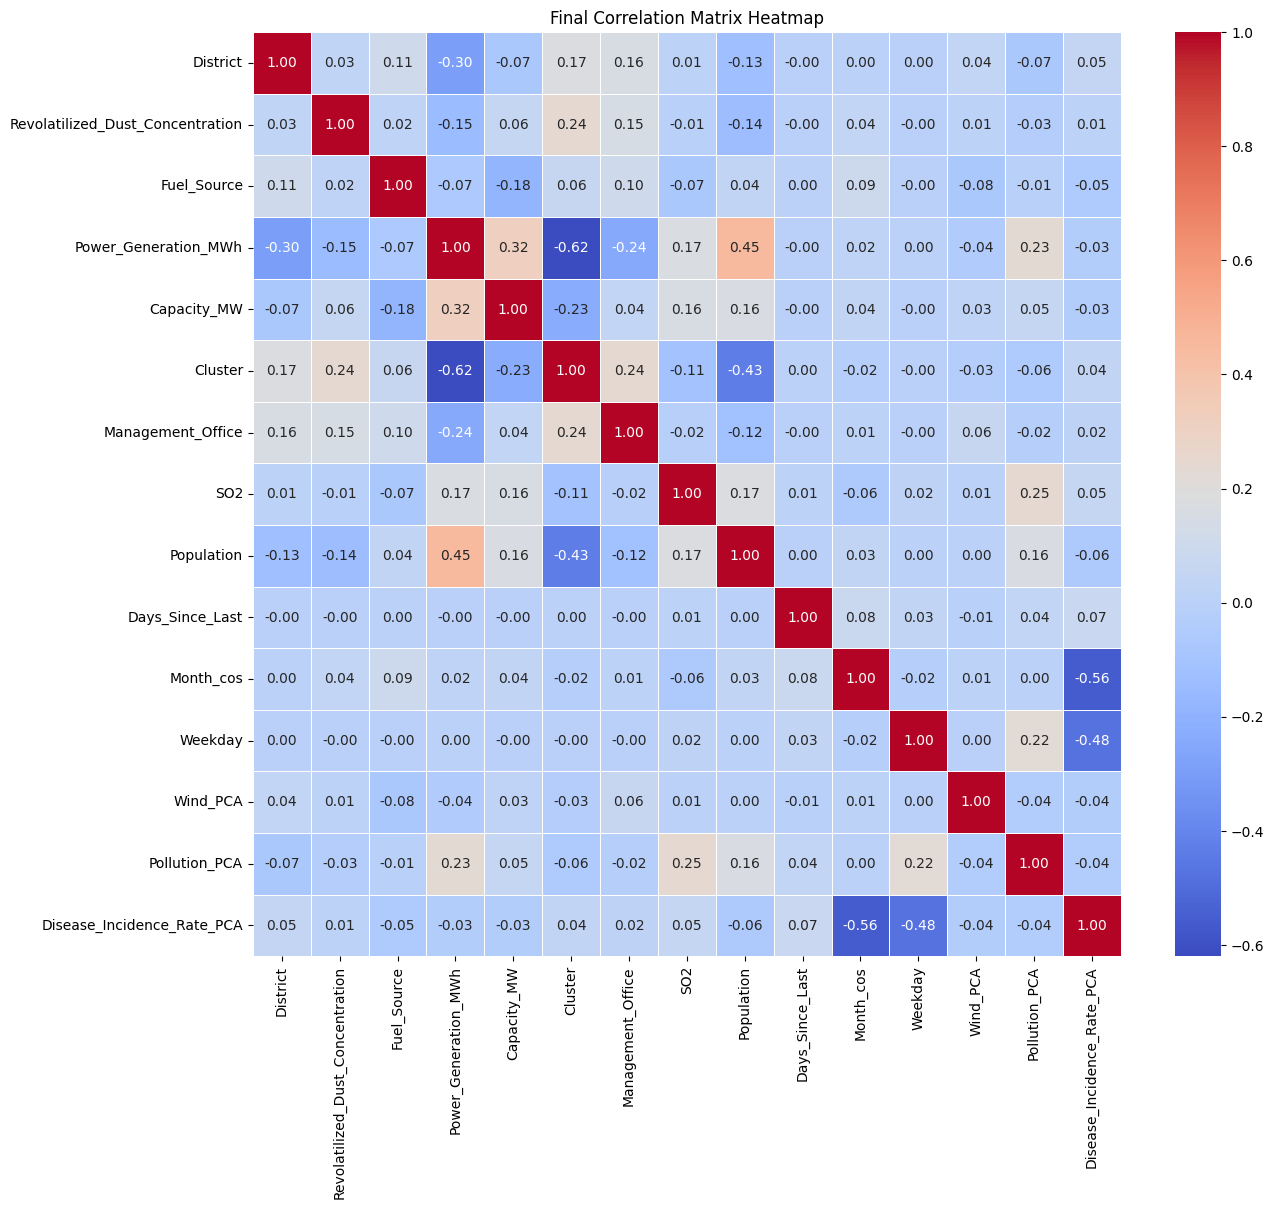

,feature,VIF
0,District,3.988353
1,Revolatilized_Dust_Concentration,10.552386
2,Fuel_Source,1.091824
3,Power_Generation_MWh,3.440396
4,Capacity_MW,9.278962
5,Cluster,4.044778
6,Management_Office,4.357554
7,SO2,7.981851
8,Population,2.409116
9,Days_Since_Last,1.043239


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 컬럼명 영문으로 변경
data.columns = [
    'Longitude_x', 'Latitude_x', 'District', 'Avg_Wind_Speed_x', 'Max_Wind_Direction_deg_x',
    'Revolatilized_Dust_Concentration', 'Fuel_Source', 'Power_Generation_MWh', 'Capacity_MW',
    'Cluster', 'Management_Office', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'Population',
    'Cold_Incidence_Rate', 'Eye_Disease_Incidence_Rate', 'Asthma_Incidence_Rate',
    'Dermatitis_Incidence_Rate', 'Days_Since_Last', 'Month_sin', 'Month_cos', 'Weekday'
]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

# VIF 값이 높은 변수 제거
data_reduced = data.drop(columns=['Longitude_x', 'Latitude_x', 'Month_sin'])


# 주성분 분석 (PCA) 적용
# 대기오염 물질 관련 변수들(SO2, CO, O3, NO2, PM25)을 주성분 분석으로 결합
wind_data = data_reduced[['Avg_Wind_Speed_x', 'Max_Wind_Direction_deg_x']]
pca = PCA(n_components=1)
data_reduced['Wind_PCA'] = pca.fit_transform(wind_data)

# 대기오염 물질 관련 변수들(SO2, CO, O3, NO2, PM25)을 주성분 분석으로 결합
pollution_data = data_reduced[['CO', 'O3', 'NO2', 'PM10', 'PM25']]
pca = PCA(n_components=1)
data_reduced['Pollution_PCA'] = pca.fit_transform(pollution_data)
# 질병 ('Cold_Incidence_Rate', 'Eye_Disease_Incidence_Rate', 'Asthma_Incidence_Rate', 'Dermatitis_Incidence_Rate')을 주성분 분석으로 결합
Disease_data = data_reduced[['Cold_Incidence_Rate', 'Eye_Disease_Incidence_Rate', 'Asthma_Incidence_Rate', 'Dermatitis_Incidence_Rate']]
pca = PCA(n_components=1)
data_reduced['Disease_Incidence_Rate_PCA'] = pca.fit_transform(Disease_data)


# 기존 대기오염 물질 변수 제거
data_final = data_reduced.drop(columns=['Avg_Wind_Speed_x', 'Max_Wind_Direction_deg_x','CO', 'O3', 'NO2', 'PM10', 'PM25', 'Cold_Incidence_Rate', 'Eye_Disease_Incidence_Rate', 'Asthma_Incidence_Rate', 'Dermatitis_Incidence_Rate'])

# 상관 행렬 계산 및 히트맵 그리기
corr_matrix_final = data_final.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_final, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap')
plt.show()

# VIF 계산
X_final = data_final.dropna()._get_numeric_data()
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(len(X_final.columns))]

vif_data_final